In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

##### Считываем данные

In [19]:
data_weather =  pd.read_excel('./weatherSPB_2016_2019.xls', sheet_name = 'weather', 
                              parse_dates = ['date_time'], 
                              usecols = ['date_time', 'T', 'U', 'Td'])

# Конвертация поля date_time из типа object в тип datetime64
data_weather['date_time'] = data_weather['date_time'].astype('datetime64[ns]')

# Удаление Series с пустыми значениями
data_weather = data_weather.dropna(how = 'any', axis = 0)

# Запись данных в новые поля month и year
data_weather['month'] = data_weather['date_time'].dt.month
data_weather['year'] = data_weather['date_time'].dt.year

##### Перевод чисел в название месяцев

In [11]:
def month_name_rus(num):
    """Функция, для преобразования числа в название месяца на русском языке"""
    
    ru = ['январь', 'февраль', 'март', 'апрель', 'май', 'июнь', 'июль', 'август', 'сентябрь',
          'октябрь', 'ноябрь', 'декабрь']
    return ru[num - 1]

##### Поиск максимальной и минимальной температуры

In [12]:
def min_max_search(df):
    """Функция для поиска максимального и минимального значения температуры из входного DataFrame"""
    
    # Создание DataFrame min_max_df и запись в него min и max от T
    min_max_df = df.groupby('month', as_index=False).agg({'T': ['min', 'max']})
    
    # Применение функции month_name_rus к полю month
    min_max_df['month'] = min_max_df['month'].apply(month_name_rus)
    
    # Переименование колонок
    min_max_df.columns = ['Месяц', 'Минимальная T', 'Максимальная T']
    
    # Запись в Excel
    min_max_df.to_excel('./output_min_max_t.xls', index=False)

    return min_max_df

##### Прогнозирование погоды

In [13]:
def forecast_weather(df):
    """Функиця прогнозирования температуры на январь 2020 года"""
    
    # Создание нового DataFrame для обучения
    jan_df = df[(df['month'] == 1)]
    jan_df = jan_df.dropna(how='any', axis=0)

    # Создание тестовых и обучаемых данных
    features = jan_df.drop(['T', 'date_time', 'month', 'year'], axis=1)
    temp = jan_df['T']
    X_train, X_test, Y_train, Y_test = train_test_split(features, temp, test_size=0.2, shuffle=False)

    # Создание и тренировка объекта линейной регрессии
    regressor = LinearRegression()
    regressor.fit(X_train, Y_train)

    # Создание DataFrame с датами января
    input_df_result = pd.DataFrame(pd.date_range(start='1/1/2020', end='31/1/2020'), columns=['Дата'])

    # Выбор 31 дня из предсказанных данных
    pred = regressor.predict(X_test)[:31]

    # Добавление данных о предсказанной температуре
    input_df_result = pd.concat([input_df_result, pd.DataFrame(pred, columns=["Температура"])], axis=1)

    # Преобразование вывода температуры
    input_df_result['Температура'] = input_df_result['Температура'].map('{:,.1f}'.format).astype('float64')

    # Запись в Excel
    input_df_result.to_excel('./predict_weather.xls', index=False)

    # Средняя квадратичная ошибка
    mse = mean_squared_error(Y_test, regressor.predict(X_test))
    print("MSE", mse)
    
    return input_df_result


##### Вызов функций

In [17]:
min_max_search(data_weather)
forecast_weather(data_weather)

MSE 0.011323081452484477


,Дата,Температура
0,2020-01-01,-6.8
1,2020-01-02,-7.4
2,2020-01-03,-7.5
3,2020-01-04,-7.9
4,2020-01-05,-8.1
5,2020-01-06,-8.3
6,2020-01-07,-8.2
7,2020-01-08,-5.5
8,2020-01-09,-5.3
9,2020-01-10,-6.7


##### Построение графика

MSE 0.011323081452484477


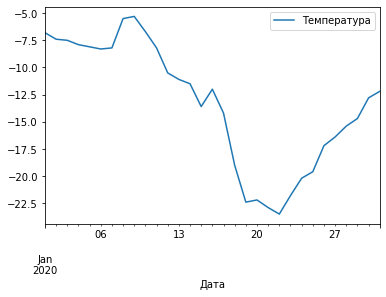

,T,U,Td,month,year
T,1.000000,-0.433914,0.897906,0.247783,0.034783
U,-0.433914,1.000000,-0.002346,0.097212,-0.147033
Td,0.897906,-0.002346,1.000000,0.327401,-0.026414
month,0.247783,0.097212,0.327401,1.000000,0.001442
year,0.034783,-0.147033,-0.026414,0.001442,1.000000


In [16]:
forecast_weather(data_weather).plot(x='Дата', y=['Температура'])
plt.show()

data_weather['T'].corr(data_weather['U'])
data_weather.corr()